![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
from collections import Counter
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

filenames_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filenames_list.append(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import os
print(os.listdir("/kaggle/working"))

/kaggle/input/world-cities-database/LICENSE.txt
/kaggle/input/world-cities-database/worldcitiespop.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/countries-travel-inbound-dataset-19952018/global_travel_inbound.xls
/kaggle/input/countries-travel-inbound-dataset-19952018/china_outbound.xlsx
/kaggle/input/world-cities/worldcities.csv
['__notebook__.ipynb']


In [2]:
cities_pop_filename = '/kaggle/input/world-cities/worldcities.csv'
cities_pop_filename

'/kaggle/input/world-cities/worldcities.csv'

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Завернем модель в функцию для того, чтобы было удобнее вызывать

def model_func(df_preproc):
    # выделим тестовую часть
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.Rating.values            # наш таргет
    X = train_data.drop(['Rating'], axis=1)
    
    RANDOM_SEED = 42
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    
    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    
    result = metrics.mean_absolute_error(y_test, y_pred)
    
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    
    plt.show
    
    return result

# DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [7]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Предобработка и анализ данных, создание новых признаков

## 1. Обработка NAN 

In [8]:
# обработаем столбец Number of Reviews
number_rew_nan = pd.isna(data['Number of Reviews']).astype('uint8')

number_rew_nan.name = 'number_rew_nan'
number_rew_nan.value_counts()

0    46800
1     3200
Name: number_rew_nan, dtype: int64

In [9]:
# Далее заполняем пропуски нулем

#mean = data['Number of Reviews'].mean()
number_rew = data['Number of Reviews'].fillna(0)

number_rew.name = 'number_rew'
number_rew.sample(5)

16167     11.0
34787     10.0
38542    255.0
25165      4.0
13970    433.0
Name: number_rew, dtype: float64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.4253625733901515

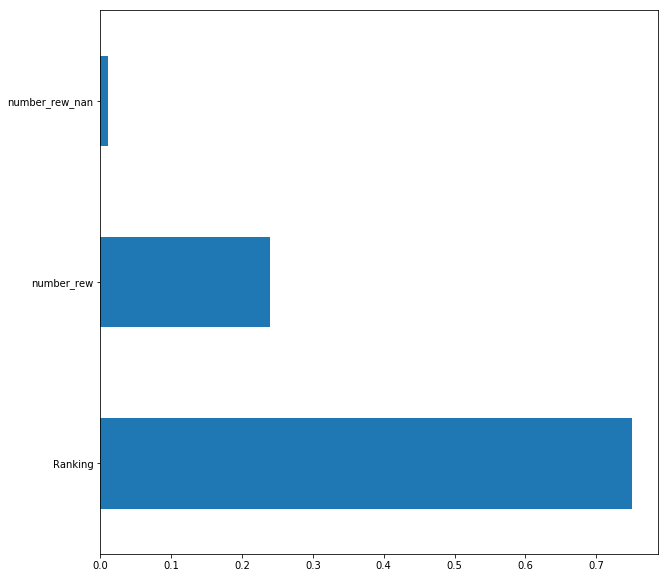

In [10]:
# проверим модель на имеющихся числовых признаках без обработки

df_preproc = pd.concat([data.loc[:,['Rating', 'sample','Ranking']], number_rew, number_rew_nan], axis = 1)
model_func(df_preproc)

Отклонение предсказания - большое. Попробуем путем предобработки и создания новых признаков улучшить предсказание модели

In [11]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

Мы видим, что другие числовые столбцы не содержат пропусков, поэтому перейдем к следующему шагу.

## 2. Создадим новые числовые признаки

In [12]:
data['Number of Reviews'].fillna(0, inplace = True)

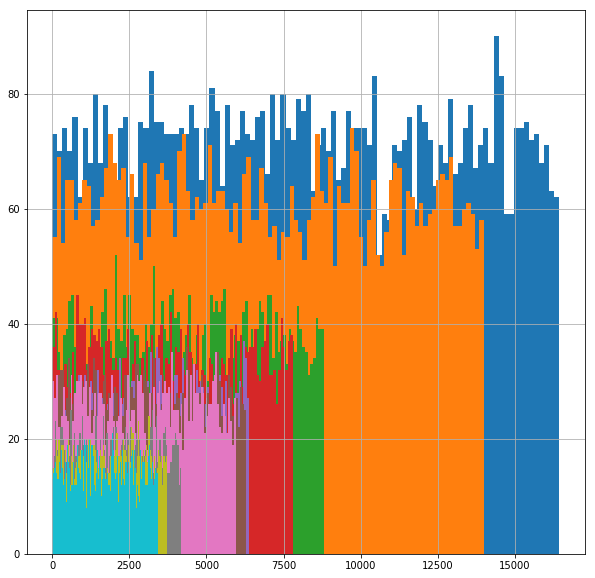

In [13]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. 
Попробуем использовать этот факт для нормализации Ranking.

In [14]:
data[data.City == 'London'].describe()

,Ranking,Number of Reviews,sample,Rating
count,7193.000000,7193.000000,7193.000000,7193.000000
mean,8169.707354,129.816488,0.800361,3.165508
std,4723.964027,321.937972,0.399756,1.698275
min,1.000000,0.000000,0.000000,0.000000
25%,4101.000000,7.000000,1.000000,3.000000
50%,8092.000000,32.000000,1.000000,4.000000
75%,12282.000000,121.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


In [15]:
data[(data.City == 'London') & (data.Rating == 5)].loc[:,['Number of Reviews', 'Ranking']].\
sort_values('Ranking', ascending = False).iloc[:10,]

,Number of Reviews,Ranking
16133,0.0,16287.0
13461,0.0,16036.0
11848,0.0,15979.0
33140,3.0,15946.0
16891,2.0,15905.0
38037,62.0,15639.0
25991,2.0,15516.0
26424,5.0,13870.0
30616,5.0,13245.0
35566,5.0,13156.0


<Figure size 360x360 with 0 Axes>

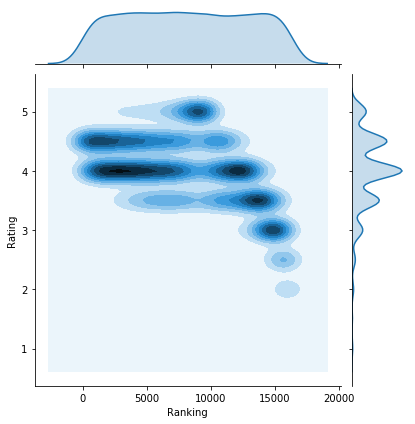

In [16]:
plt.figure(figsize = (5,5))
sns.jointplot(data = data[(data.City == 'London') & (data.Rating > 0)], x = 'Ranking', y = 'Rating', kind = 'kde')

Получается, что самые популярные рестораны (минимальный Ranking) имеют Rating равный примерно 4 баллам.
Но есть рестораны с высоким рейтингом 5, но по ранку расположенные примерно посередине. Это будет верно, например, для локальной забегаловки для местных, в которой не много посетителей, но которые все ставят ей стабильно 5.


In [17]:
# создадим признак, который на основании Ranking вычисляет значение Rating. Зависимость линейная
# f(1) = 5 и f(n) = 1 при f(x) = k*x + b

max_rank_by_city = data.groupby(['City']).max().Ranking

def true_rating(row):
    return round(5 - 4*(1 - row['Ranking'])/(1 - max_rank_by_city[row['City']]),1)

data['rating_by_rank'] = data.apply(true_rating, axis = 1)
data['rating_by_rank'].sort_values()

24269    1.0
44463    1.0
8066     1.0
22943    1.0
41175    1.0
        ... 
1677     5.0
14046    5.0
8524     5.0
18447    5.0
40566    5.0
Name: rating_by_rank, Length: 50000, dtype: float64

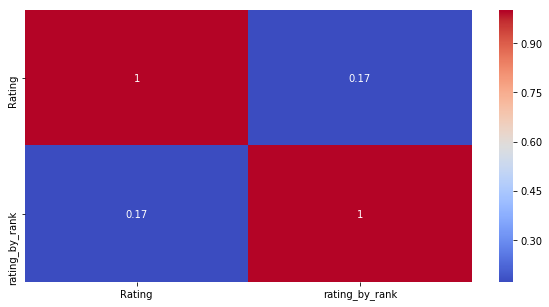

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax = sns.heatmap(data.loc[data.City == 'London',['Rating', 'rating_by_rank']].corr(),annot = True, cmap = 'coolwarm')

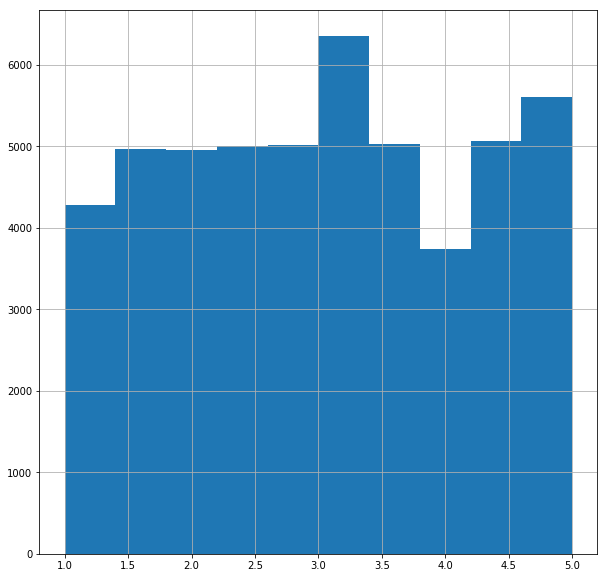

In [19]:
data['rating_by_rank'].hist()

Новый признак, построенный из Ranking путем лин. преобразования, тем не менее = равномерен и нормален.

In [20]:
data[(data.City == 'London') & (data.Rating == 5)].loc[:,['Number of Reviews', 'Ranking', 'rating_by_rank']].\
sort_values('Ranking', ascending = False).iloc[:20,]

,Number of Reviews,Ranking,rating_by_rank
16133,0.0,16287.0,1.0
13461,0.0,16036.0,1.1
11848,0.0,15979.0,1.1
33140,3.0,15946.0,1.1
16891,2.0,15905.0,1.1
38037,62.0,15639.0,1.2
25991,2.0,15516.0,1.2
26424,5.0,13870.0,1.6
30616,5.0,13245.0,1.8
35566,5.0,13156.0,1.8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.2651142784144529

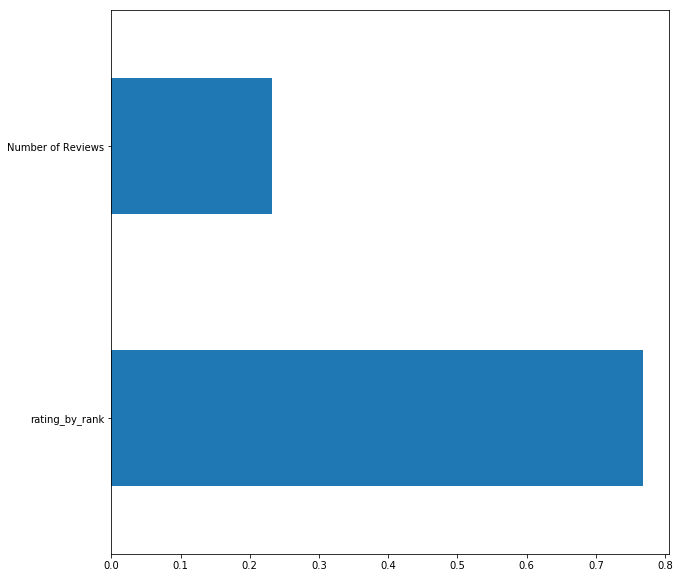

In [21]:
df_preproc = pd.concat([data.loc[:,['Number of Reviews','rating_by_rank']], data.loc[:,['Rating', 'sample']]], axis = 1)
model_func(df_preproc)

После обработки Ranking предсказание модели значительно улучшилось.

In [22]:
rating_by_rank = data['rating_by_rank']

In [23]:
data[data.City == 'London'].loc[:,['Number of Reviews', 'Ranking', 'rating_by_rank','Rating']].\
sort_values('rating_by_rank', ascending = True).iloc[:20,]

,Number of Reviews,Ranking,rating_by_rank,Rating
9558,0.0,16395.0,1.0,0.0
559,0.0,16327.0,1.0,0.0
43981,0.0,16333.0,1.0,1.0
23494,0.0,16418.0,1.0,1.0
1839,4.0,16292.0,1.0,0.0
43994,5.0,16296.0,1.0,1.0
46965,3.0,16308.0,1.0,1.0
3411,16.0,16250.0,1.0,0.0
35016,0.0,16435.0,1.0,1.0
36040,0.0,16386.0,1.0,1.0


In [24]:
# создадим еще один признак на основе Ranking, проверим, какой работает лучше
# просто поделим Ranking на макс. значение в городе

def norm_rank_funk(row):
    return round(row['Ranking']*100/max_rank_by_city[row['City']],5)

norm_rank = data.apply(norm_rank_funk, axis = 1)
norm_rank.name = 'norm_rank'
norm_rank.sort_values()

15936      0.00608
17199      0.01135
16194      0.01594
15441      0.01681
23446      0.02145
           ...    
25290    100.00000
22814    100.00000
49427    100.00000
17921    100.00000
14805    100.00000
Name: norm_rank, Length: 50000, dtype: float64

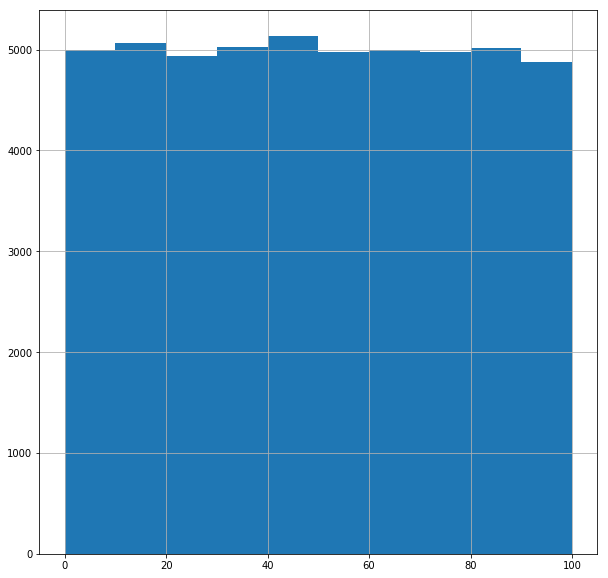

In [25]:
norm_rank.hist()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5c8e28dc50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5c8e2ad550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5c8e28d9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5c8e2adf98>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5c8e236240>],
 'means': []}

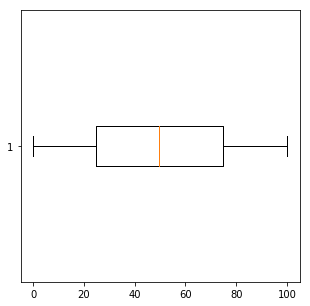

In [26]:
plt.figure(figsize = (5,5))
plt.boxplot(norm_rank, vert = False)

Новый признак также не имеет смещений и выбросов.
Посмотрим на поведение модели на новом признаке

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.26845676190476186

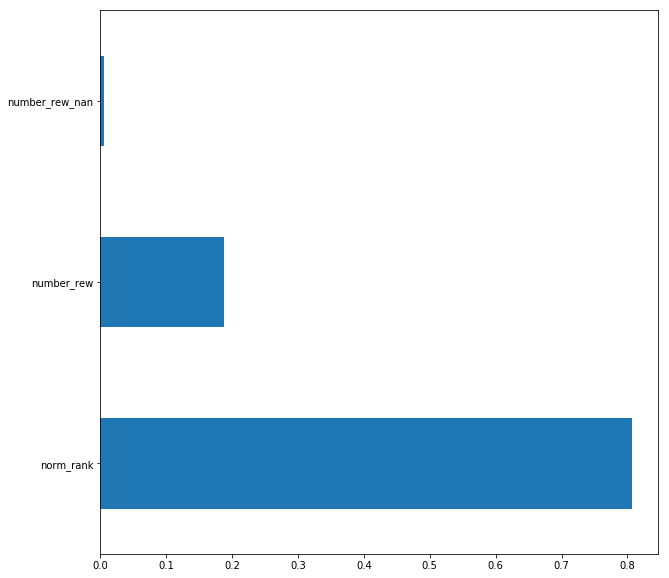

In [27]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], number_rew, number_rew_nan, norm_rank], axis = 1)
model_func(df_preproc)

Новый признак не особо повлиял на модель. Оставим для модели признак norm_rank.

In [28]:
# среднее количество отзывов в городе
mean_rews_by_city = round((data.groupby(['City']).sum()['Number of Reviews']
                           /data.groupby(['City']).max()['Ranking']),2)

mean_rews = data.City.apply(lambda x: mean_rews_by_city[x])
mean_rews.name = 'mean_rews'
mean_rews.sample(5)

18364     55.08
38922     25.83
46487     56.78
17848     54.15
22797    122.43
Name: mean_rews, dtype: float64

In [29]:
# два признака для количество ресторанов в городе, один на основе макс Ranking, другой просто по количеству записей в городе

max_rank = data.City.apply(lambda x: max_rank_by_city[x])
max_rank.name = 'max_rank'

places_counts_by_sity = data.groupby(['City']).count().Ranking
places_counts = data.City.apply(lambda x: places_counts_by_sity[x])
places_counts.name = 'places_counts'

pd.concat([max_rank, places_counts], axis = 1).sample(10)

,max_rank,places_counts
28138,1766.0,745
39059,6372.0,2705
30879,3254.0,1372
20326,6275.0,2694
36852,2737.0,1186
14473,3254.0,1372
34544,2666.0,1126
22075,1137.0,488
5147,8809.0,3813
47604,2737.0,1186


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.207701875

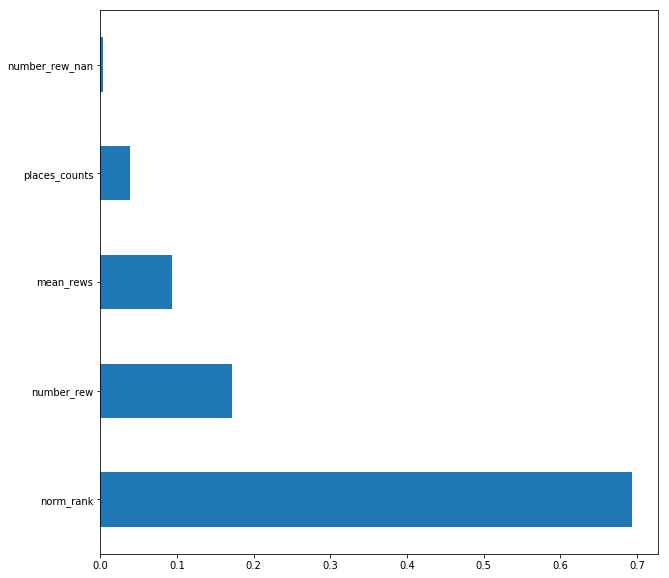

In [30]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], number_rew, number_rew_nan, norm_rank, mean_rews, places_counts], axis = 1)
model_func(df_preproc)

Модель улучшилась.

### Склеим все новые признаки и посмотирм на матрицу корреляции

In [31]:
X = pd.concat([number_rew, norm_rank, rating_by_rank, mean_rews, places_counts, data['Rating']], axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
number_rew        50000 non-null float64
norm_rank         50000 non-null float64
rating_by_rank    50000 non-null float64
mean_rews         50000 non-null float64
places_counts     50000 non-null int64
Rating            50000 non-null float64
dtypes: float64(5), int64(1)
memory usage: 2.3 MB


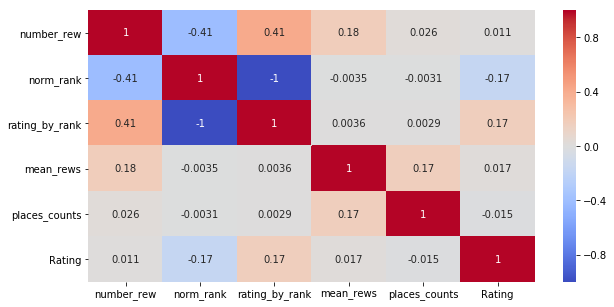

In [32]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax = sns.heatmap(X.corr(),annot = True, cmap = 'coolwarm')

Очевидно, что признаки norm_rank и rating_by_rank имеют корреляцию = -1, так как получены один из другого путем линейного преобразования.

## 3. Обработка категориальных признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    50000 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
rating_by_rank       50000 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 4.6+ MB


Посмотрим на признак City. Является ли он значимым для модели?

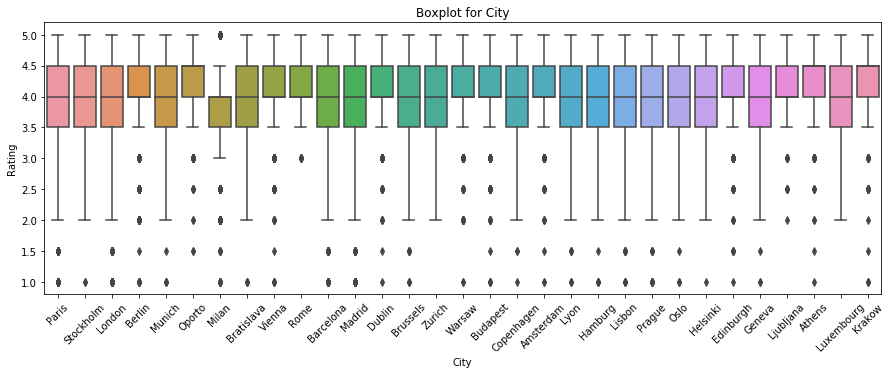

In [34]:
all_cities = data.City.value_counts().index

fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='City', y='Rating',data=data[data.Rating > 0],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

Признак, очевидно, значим для определения Rating

In [35]:
# выделим список с городами, боксплоты которых отличаются от остальных
phen_cities = [ i for i in all_cities if data[data.City == i].quantile(q = 0.75).Rating - data[data.City == i].quantile(q = 0.25).Rating != 1.5]
phen_cities  

['Madrid',
 'Rome',
 'Brussels',
 'Lyon',
 'Stockholm',
 'Athens',
 'Oslo',
 'Bratislava',
 'Luxembourg',
 'Ljubljana']

### 3.1. Сконструируем dummy-признаки из City

In [36]:
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [37]:
# создадим отдельный признак с городами, у которых боксплоты отличаются от остальных

data['phen_cities'] = data.City.apply(lambda x: x if x in phen_cities else 'other')
data['phen_cities'].value_counts()

other         37996
Madrid         3813
Rome           2589
Brussels       1314
Lyon           1126
Stockholm      1033
Athens          776
Oslo            488
Bratislava      380
Luxembourg      263
Ljubljana       222
Name: phen_cities, dtype: int64

In [38]:
# воспользуемся get_dummies

cities = pd.get_dummies(data.City, columns=[ 'City'])
cities.sample(5)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
21096,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [39]:
phen_cities_dummy = pd.get_dummies(data.phen_cities, columns=[ 'phen_cities'])
phen_cities_dummy.sample(5)

,Athens,Bratislava,Brussels,Ljubljana,Luxembourg,Lyon,Madrid,Oslo,Rome,Stockholm,other
6432,0,0,0,0,0,0,0,0,0,0,1
9014,0,0,0,0,0,0,0,0,0,0,1
12240,0,0,0,0,0,0,0,0,0,0,1
33215,0,0,0,0,0,0,1,0,0,0,0
7036,0,0,0,0,0,0,0,0,0,0,1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.20698124999999998

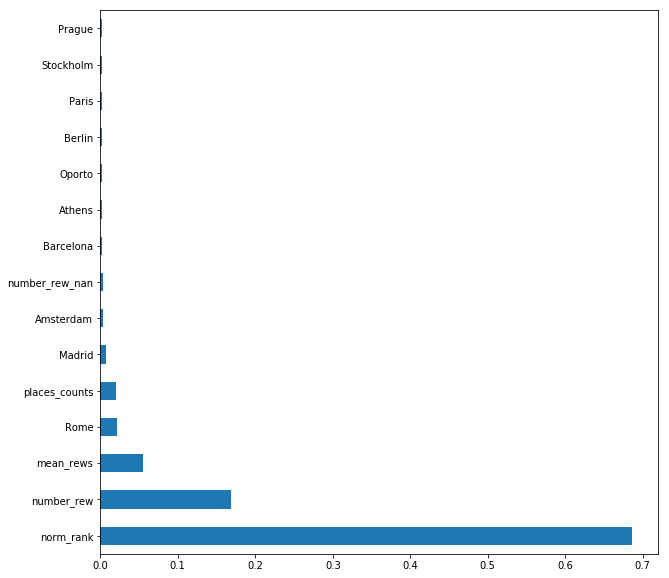

In [40]:
# проверим дамми признаки на модели

df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities], axis = 1)
model_func(df_preproc)

Модель дает более точное предсказание на всех городах. Оставим для модели cities

### 3.2. Обработаем признак "Price Range".

In [41]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [42]:
data['Price Range'].isna().sum()

17361

In [43]:
# Пропусков в цене много. Выделим пропуски в цене в отдельный признак

price_isnan = pd.isna(data['Price Range']).astype('uint8')
price_isnan.name = 'price_isnan'

In [44]:
# Определим функцию для заполнения Price Range

def price_ordinal(price):
    if price == '$':
        result = 1
    elif price == '$$ - $$$':
        result = 2
    elif price == '$$$$':
        result = 3
    else:
        result = 0
    return result

prices = data['Price Range'].apply(price_ordinal)
prices.name = 'prices'

prices.value_counts()

2    23041
0    17361
1     7816
3     1782
Name: prices, dtype: int64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.204948125

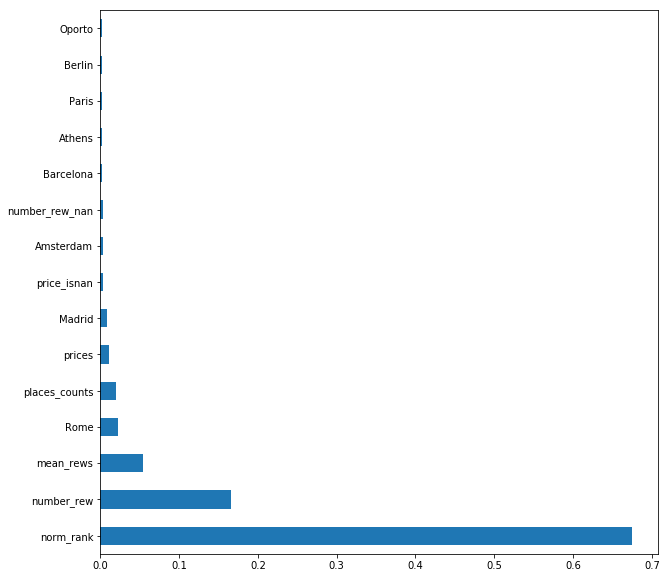

In [45]:
# проверим модель с обработанной ценой

df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan], axis = 1)
model_func(df_preproc)

### 3.3. Обработаем Cuisine Style

In [46]:
# посмотрим, сколько всего стилей кухни встречается датасете

cuisine_styles = Counter()

for i in data['Cuisine Style'].dropna():
    l = re.sub('\s\'|\'','', i)[1:-1].split(',')
    cuisine_styles.update(l)

cuisines = [x[0] for x in cuisine_styles.most_common()]

len(cuisines)


125

In [47]:
cuisine_styles.most_common()

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish', 453),
 ('Scandinavi

In [48]:
cuisine_most_common = [x[0] for x in cuisine_styles.most_common()[:10]]
cuisine_most_common

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza']

In [49]:
# превратим Cuisine Style в список

cuisine_style = data['Cuisine Style'].apply(lambda x: ['other_style'] if pd.isnull(x) else x[1:-1].split(',') )
cuisine_style.sample(5)

5472                                         [other_style]
28928                                ['Chinese',  'Asian']
12149                                        [other_style]
29639                          ['Mediterranean',  'Greek']
24869    ['Italian',  'French',  'Mediterranean',  'Eur...
Name: Cuisine Style, dtype: object

In [50]:
# добавим новый признак "Количество кухонь в ресторане"

cuisine_counts = cuisine_style.apply(lambda x: len(x))
cuisine_counts.name = 'cuisine_counts'

cuisine_counts.sample(5)

17809    4
4650     3
27823    1
17375    2
43993    1
Name: cuisine_counts, dtype: int64

Изменим столбец Cuisine Style так: если стиль кухни ресторана попадает в самые частые значения, то оставляем его, если нет, меняем на other_style

In [51]:
for i,k in enumerate(cuisine_style):
    new_list = []
    for j in k:
        j = re.sub('\s\'|\'','', j)
        if j in cuisine_most_common:
            new_list.append(j)
        else:
            new_list.append('other_style')
    cuisine_style.at[i] = new_list
cuisine_style.sample(5)

20899                                        [other_style]
11109                      [Bar, other_style, other_style]
17594    [Italian, other_style, other_style, Mediterran...
3545                                         [other_style]
14197    [other_style, other_style, Asian, Vegetarian F...
Name: Cuisine Style, dtype: object

Теперь добавим новые признаки, соответсвующие самым частым значениям стилей кухонь

In [52]:
cuisine_style_df = pd.DataFrame(cuisine_style)
for i in cuisine_most_common + ['other_style']:
    cuisine_style_df[i] = cuisine_style.apply(lambda x: 1 if i in x else 0).astype('uint8')

cuisine_style_df.drop('Cuisine Style', axis = 1, inplace=True)

cuisine_style_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Vegetarian Friendly    50000 non-null uint8
European               50000 non-null uint8
Mediterranean          50000 non-null uint8
Italian                50000 non-null uint8
Vegan Options          50000 non-null uint8
Gluten Free Options    50000 non-null uint8
Bar                    50000 non-null uint8
French                 50000 non-null uint8
Asian                  50000 non-null uint8
Pizza                  50000 non-null uint8
other_style            50000 non-null uint8
dtypes: uint8(11)
memory usage: 537.2 KB


In [53]:
cuisine_style_df.sample(5)

,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,other_style
15655,0,0,0,1,0,0,0,0,0,0,1
35112,1,0,0,0,1,0,0,0,1,0,1
49755,0,0,0,0,0,0,0,0,0,0,1
46826,0,0,0,0,0,0,0,1,0,0,0
9698,0,0,0,0,0,0,0,0,0,0,1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.20366249999999997

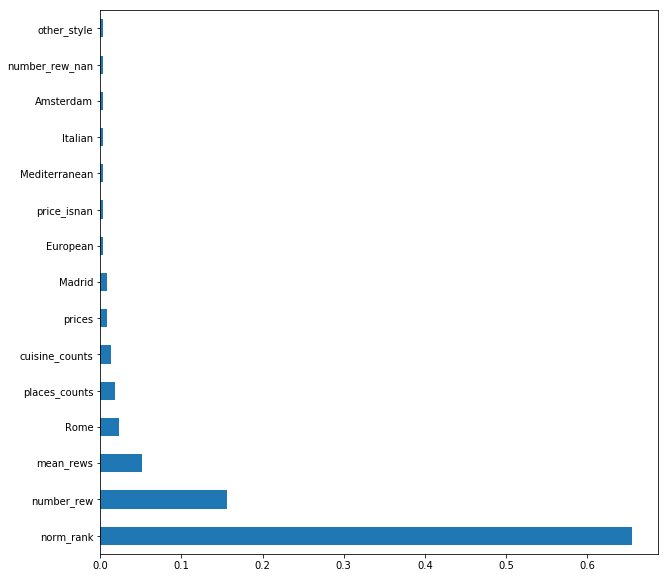

In [54]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df], axis = 1)
model_func(df_preproc)

In [55]:
data['Cuisine Style'].isna().sum()

11590

In [56]:
data['Cuisine Style'].fillna('other_style', inplace = True)

### 3.4. Теперь обработаем Reviews
Выделим даты обзоров и посчитаем, сколько времени прошло между двумя обзорами

In [57]:
data['rew_dates'] = data.Reviews.apply(lambda x : [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))
data['max_rew_date'] = pd.to_datetime(data['rew_dates'].apply(lambda x: max(x)))

data['first_rew'] = pd.to_datetime(data['rew_dates'].apply(lambda x : x[0]))
data['second_rew'] = pd.to_datetime(data['rew_dates'].apply(lambda x: x[1] if len(x) == 2 else ''))

rew_delta = np.abs(data['first_rew'] - data['second_rew'])
rew_delta = rew_delta.apply(lambda x: x.days)

rew_delta.name = 'rew_delta'

rew_delta.sample(5)

38365    196.0
48275     18.0
3338       3.0
22083    165.0
24787      NaN
Name: rew_delta, dtype: float64

In [58]:
rew_delta.isna().sum()

13794

Пропусокв очень много, выделим отдельный признак для них

In [59]:
# пустых значений много, сделаем новый признак для NAN
rew_delta_isnan = pd.isna(rew_delta).astype('uint8')

rew_delta_isnan.value_counts()

0    36206
1    13794
Name: rew_delta, dtype: int64

In [60]:
# Заполним пропуски средним

mean = round(rew_delta.mean(), 2)
rew_delta = rew_delta.fillna(mean)
rew_delta.sample(5)

39110    270.0
33657      7.0
18507     26.0
36871     23.0
15779    174.0
Name: rew_delta, dtype: float64

Создадим еще один признак для даты: количество дней, прошедшее между текущей датой и последним отзывом

In [61]:
from datetime import datetime

rew_delta_cur = (datetime.now() - data['max_rew_date'])
rew_delta_cur = rew_delta_cur.fillna(rew_delta_cur.median())

rew_delta_cur = rew_delta_cur.apply(lambda x : x.days)

rew_delta_cur.name = 'rew_delta_cur'

rew_delta_cur.sample(5)

3805     1585
10741    1219
21855    1162
43071    1137
31077    1815
Name: rew_delta_cur, dtype: int64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.198221875

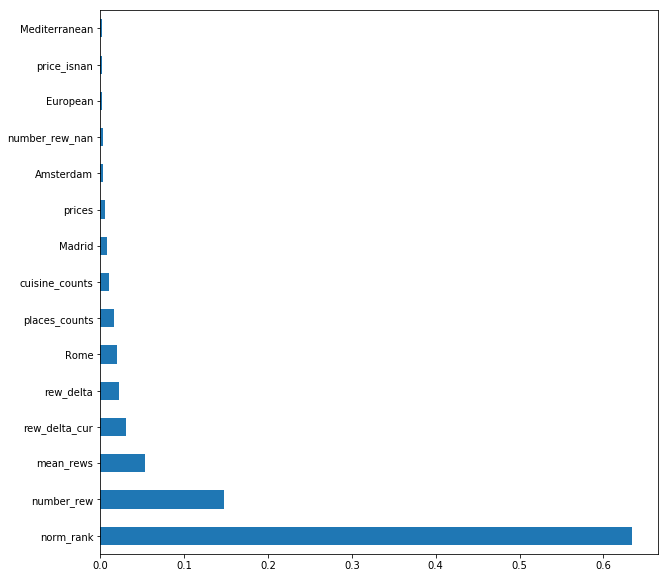

In [62]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan], axis = 1)
model_func(df_preproc)

### 3.5. Сконструируем новый признак "Население города" на основе внешних данных

In [63]:
data_add = pd.read_csv(cities_pop_filename)
data_add.sample(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2050,Kovin,Kovin,44.7482,20.9766,Serbia,RS,SRB,Kovin,admin,NaN,1688830508
9156,Prairie View,Prairie View,30.0850,-95.9897,United States,US,USA,Texas,NaN,6391.0,1840021698
11385,Mooresville,Mooresville,39.6038,-86.3674,United States,US,USA,Indiana,NaN,9641.0,1840009668


In [64]:
cities_info = pd.DataFrame(data.City.value_counts().index)
cities_info.columns = ['city']
cities_info.head(3)

,city
0,London
1,Paris
2,Madrid


In [65]:
data_europe = data_add[data_add.iso2.apply(lambda x: x not in ('US','CA','VE'))]
data_europe.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [66]:
cities_country = cities_info.merge(data_europe, how = 'left', on = 'city').loc[:, ['city', 'iso2']]
cities_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 2 columns):
city    31 non-null object
iso2    27 non-null object
dtypes: object(2)
memory usage: 744.0+ bytes


In [67]:
cities_country[cities_country.iso2.isna()]

,city,iso2
19,Copenhagen,NaN
22,Zurich,NaN
23,Oporto,NaN
25,Krakow,NaN


In [68]:
cities_country.at[23,'iso2'] = 'PT'
cities_country.at[25,'iso2'] = 'PL'
cities_country.at[22,'iso2'] = 'CH'
cities_country.at[19,'iso2'] = 'DK'
cities_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 2 columns):
city    31 non-null object
iso2    31 non-null object
dtypes: object(2)
memory usage: 2.0+ KB


In [69]:
cities_info = cities_info.merge(data_europe.loc[:,['city','capital', 'population']], how = 'left', on = 'city')
cities_info.sample(5)

,city,capital,population
28,Bratislava,primary,423737.0
6,Rome,primary,3339000.0
15,Stockholm,primary,1264000.0
5,Milan,admin,2945000.0
20,Athens,primary,3242000.0


In [70]:
cities_info.isna().sum()

city          0
capital       4
population    4
dtype: int64

In [71]:
cities_info['capital'] = cities_info.capital.fillna('not_cap')

In [72]:
cities_info[cities_info.population.isna()]

,city,capital,population
19,Copenhagen,not_cap,NaN
22,Zurich,not_cap,NaN
23,Oporto,not_cap,NaN
25,Krakow,not_cap,NaN


In [73]:
# заполним пропуски в населении и странах
cities_info.at[23,'population'] = 237591
cities_info.at[25,'population'] = 769498
cities_info.at[22,'population'] = 428737
cities_info.at[19,'population'] = 615993

In [74]:
cities_info.columns =  ['City', 'capital', 'population']
cities_country.columns = ['City', 'country']

In [75]:
# объединим с исходным датасетом

cities_pop = data.loc[:,['City']].merge(cities_info, how = 'left', on = 'City')

cities_pop.drop(['City'], axis = 1, inplace = True)

cities_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 2 columns):
capital       50000 non-null object
population    50000 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [76]:
cities_capital = pd.get_dummies(cities_pop.capital)
cities_pop.drop(['capital'], axis = 1, inplace = True)

cities_capital.sample(5)

,admin,not_cap,primary
48827,0,0,1
46926,0,1,0
6919,0,0,1
7613,0,0,1
35220,0,0,1


In [77]:
# добавим дамми признаки для стран
countries = data.loc[:,['City']].merge(cities_country, how = 'left', on = 'City')

countries.drop(['City'], axis = 1, inplace = True)
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 1 columns):
country    50000 non-null object
dtypes: object(1)
memory usage: 781.2+ KB


In [78]:
countries = pd.get_dummies(countries)
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 22 columns):
country_AT    50000 non-null uint8
country_BE    50000 non-null uint8
country_CH    50000 non-null uint8
country_CZ    50000 non-null uint8
country_DE    50000 non-null uint8
country_DK    50000 non-null uint8
country_ES    50000 non-null uint8
country_FI    50000 non-null uint8
country_FR    50000 non-null uint8
country_GB    50000 non-null uint8
country_GR    50000 non-null uint8
country_HU    50000 non-null uint8
country_IE    50000 non-null uint8
country_IT    50000 non-null uint8
country_LU    50000 non-null uint8
country_NL    50000 non-null uint8
country_NO    50000 non-null uint8
country_PL    50000 non-null uint8
country_PT    50000 non-null uint8
country_SE    50000 non-null uint8
country_SI    50000 non-null uint8
country_SK    50000 non-null uint8
dtypes: uint8(22)
memory usage: 1.4 MB


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.1976375

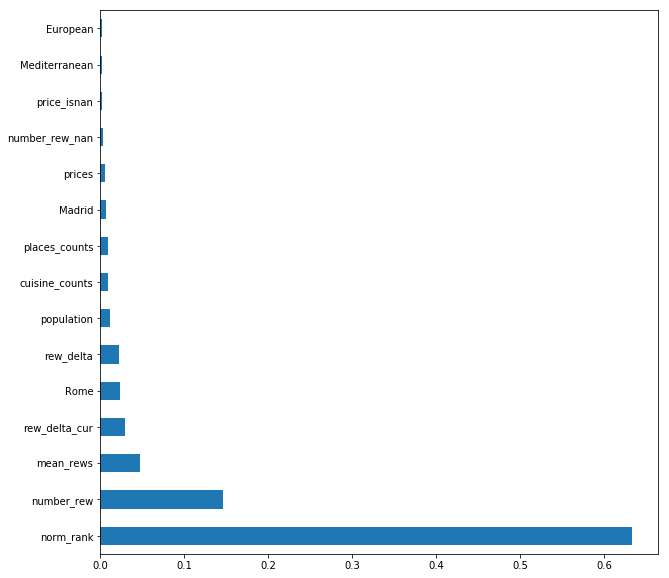

In [79]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan, \
                        cities_pop, cities_capital, countries], axis = 1)
model_func(df_preproc)

### 3.6. Количество туристов

In [80]:
cities_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 3 columns):
City          31 non-null object
capital       31 non-null object
population    31 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.2+ KB


In [81]:
cities_info['City']

0         London
1          Paris
2         Madrid
3      Barcelona
4         Berlin
5          Milan
6           Rome
7         Prague
8         Lisbon
9         Vienna
10     Amsterdam
11      Brussels
12       Hamburg
13        Munich
14          Lyon
15     Stockholm
16      Budapest
17        Warsaw
18        Dublin
19    Copenhagen
20        Athens
21     Edinburgh
22        Zurich
23        Oporto
24        Geneva
25        Krakow
26          Oslo
27      Helsinki
28    Bratislava
29    Luxembourg
30     Ljubljana
Name: City, dtype: object

In [82]:
# заведем словарь для гоордов с новыми данными [кол-во тыс. туристов, место в рейтенге благосостояния] по данным из wiki
th = {
    'London' : [19233, 14],
    'Paris' : [17560, 18],
    'Madrid' : [5440, 19],
    'Barcelona' : [6714, 19],
    'Berlin' : [5959, 15],
    'Milan' : [6481, 24],
    'Rome' : [10065, 24],
    'Prague' : [8949, 22],
    'Lisbon' : [3539, 29],
    'Vienna' : [6410, 2],
    'Amsterdam' : [8354, 7],
    'Brussels' : [3942, 13],
    'Hamburg' : [1450, 15],
    'Munich' : [4067, 15],
    'Lyon' : [6000, 18],
    'Stockholm' : [2605, 8],
    'Budapest' : [3823, 31],
    'Warsaw' : [2850, 27],
    'Dublin' : [5213, 16],
    'Copenhagen' : [3070, 5],
    'Athens' : [5728, 36],
    'Edinburgh' : [1660, 14],
    'Zurich' : [2240, 6],
    'Oporto' : [2341, 29],
    'Geneva' : [1150, 6],
    'Krakow' : [2732, 27],
    'Oslo' : [1400, 1],
    'Helsinki' : [1240, 9],
    'Bratislava' : [126, 26],
    'Luxembourg' : [1139, 11],
    'Ljubljana' : [5900, 20]
}

In [83]:
tourists = data.City.apply(lambda x : th[x][0])
tourists.name = 'tourists'

hapiness = data.City.apply(lambda x : th[x][1])
hapiness.name = 'hapiness'

tourists
hapiness

0        18
1         9
2        14
3        14
4        26
         ..
49995    24
49996    18
49997     8
49998    27
49999    24
Name: hapiness, Length: 50000, dtype: int64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.19719624999999996

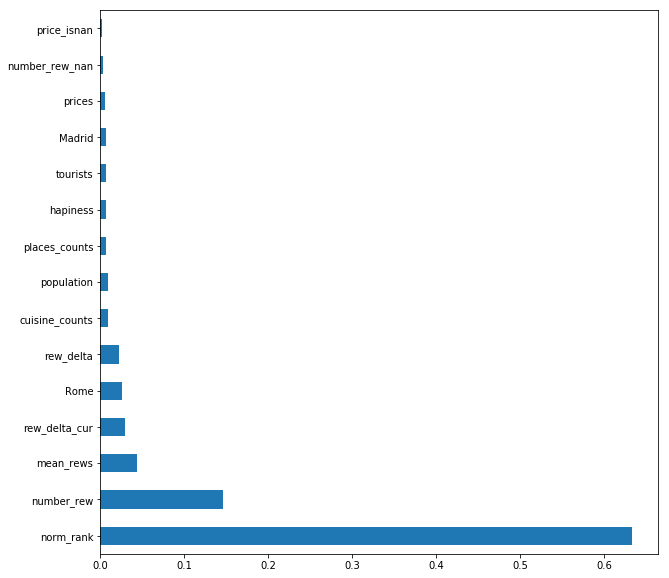

In [84]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan, \
                        cities_pop, cities_capital, countries, \
                        tourists, hapiness], axis = 1)
model_func(df_preproc)

### 3.7. Построим на основе текстов обзоров новые признаки

In [85]:
# выделим текст обзоров для последующего анализа.
data['rew_texts'] = data.Reviews.apply(lambda x : '' if pd.isna(x) else x[2:-2].split('], [')[0])

rew_texts_list = data['rew_texts'].apply(lambda x : [''] if x == '' else x.split("', '"))

data['first_text'] = rew_texts_list.apply(lambda x : x[0][1:-1] if len(x) == 1 else x[0][1:] if len(x) == 2 else '')
data['second_text'] = rew_texts_list.apply(lambda x: x[1][:-1] if len(x) == 2 else '')

data.loc[:,['Reviews', 'rew_texts', 'first_text', 'second_text']].sample(5)

,Reviews,rew_texts,first_text,second_text
11567,"[['Something fishy🐟🐠', 'Bistro in middle of Sh...","'Something fishy🐟🐠', 'Bistro in middle of Shop...",Something fishy🐟🐠,Bistro in middle of Shopping Mall
41640,"[['Excellent food', 'Hidden gem in north londo...","'Excellent food', 'Hidden gem in north london ...",Excellent food,Hidden gem in north london food is amazing...
20459,"[['Caters to Large Groups', 'Enjoyable'], ['10...","'Caters to Large Groups', 'Enjoyable'",Caters to Large Groups,Enjoyable
15041,"[['Soup for you', 'When our canteen fails, we ...","'Soup for you', 'When our canteen fails, we go...",Soup for you,"When our canteen fails, we go here"
6885,"[['Dreadful Service, okay food', 'NIce Breakfa...","'Dreadful Service, okay food', 'NIce Breakfast...","Dreadful Service, okay food","NIce Breakfast, but limited options"


In [86]:
def rew_counts_func(row):
    result = 0 if row['rew_texts'] == ''  else 1 if row['second_text'] == '' else 2
    return result
    
rew_counts = data.apply(rew_counts_func, axis = 1)
rew_counts.name = 'rew_counts'

pd.concat([rew_counts, data['rew_texts']], axis = 1)

,rew_counts,rew_texts
0,0,
1,2,"'Very good reviews!', 'Fine dining in Hakaniemi'"
2,2,"'Better than the Links', 'Ivy Black'"
3,2,"'Most exquisite', 'Delicious and authentic'"
4,2,"'Always the best in bratislava', 'Very good bu..."
...,...,...
49995,2,"'The real Italian experience!', 'Wonderful foo..."
49996,2,"'Parisian atmosphere', 'Bit pricey but interes..."
49997,2,"'Good by swedish standards', 'A hidden jewel i..."
49998,2,"'Underground restaurant', 'Oldest Restaurant i..."


In [87]:
rew_counts.value_counts()

2    34787
0     8114
1     7099
Name: rew_counts, dtype: int64

In [88]:
# количество слов в отзывах

words_count = data['rew_texts'].apply(lambda x : len(x.split()))

words_count.name = 'words_count'
pd.concat([rew_counts, data['rew_texts'], words_count], axis = 1)

,rew_counts,rew_texts,words_count
0,0,,0
1,2,"'Very good reviews!', 'Fine dining in Hakaniemi'",7
2,2,"'Better than the Links', 'Ivy Black'",6
3,2,"'Most exquisite', 'Delicious and authentic'",5
4,2,"'Always the best in bratislava', 'Very good bu...",9
...,...,...,...
49995,2,"'The real Italian experience!', 'Wonderful foo...",8
49996,2,"'Parisian atmosphere', 'Bit pricey but interes...",9
49997,2,"'Good by swedish standards', 'A hidden jewel i...",12
49998,2,"'Underground restaurant', 'Oldest Restaurant i...",6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.1968725

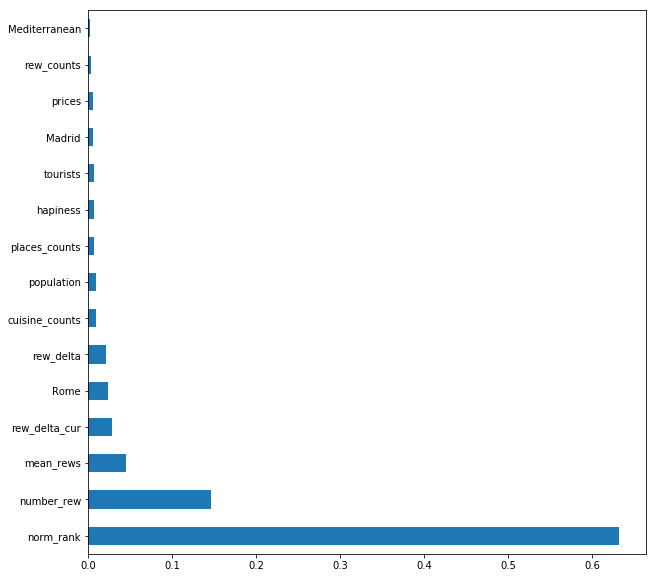

In [89]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan, \
                        cities_pop, cities_capital, countries, \
                        tourists, hapiness, \
                        rew_counts], axis = 1)
model_func(df_preproc)

Количество слов модель ухудшило. А количество отзывов - наоборот. Оставим признак rew_counts

### 3.8. На основе признаков population, tourists и Number of Reviews построим новые признаки

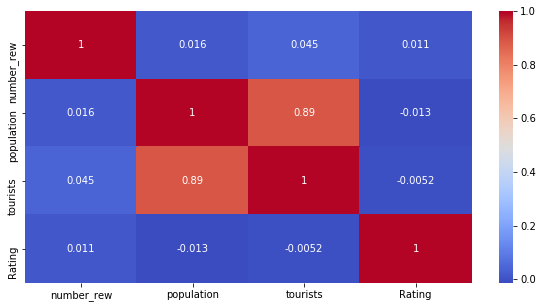

In [90]:
# посмотрим на корреляцию признаков

X = pd.concat([number_rew, cities_pop, tourists, data['Rating']], axis = 1)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax = sns.heatmap(X.corr(),annot = True, cmap = 'coolwarm')

Количество туристов и население города очень сильно положительно скоррелированы.
Попробуем использовать главную компоненту вместо этого признака.
Сначала нормируем признаки.

In [91]:
ss = StandardScaler()
cities_pop_std = pd.DataFrame(ss.fit_transform(cities_pop))
tourists_std = pd.DataFrame(ss.transform(pd.DataFrame(tourists)))

pd.concat([cities_pop_std,tourists_std], axis = 1).corr()

pop_tourists = cities_pop_std + tourists_std
pop_tourists = pd.DataFrame(ss.fit_transform(pop_tourists))

pop_tourists.name = 'pop_tourists'

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.1976025

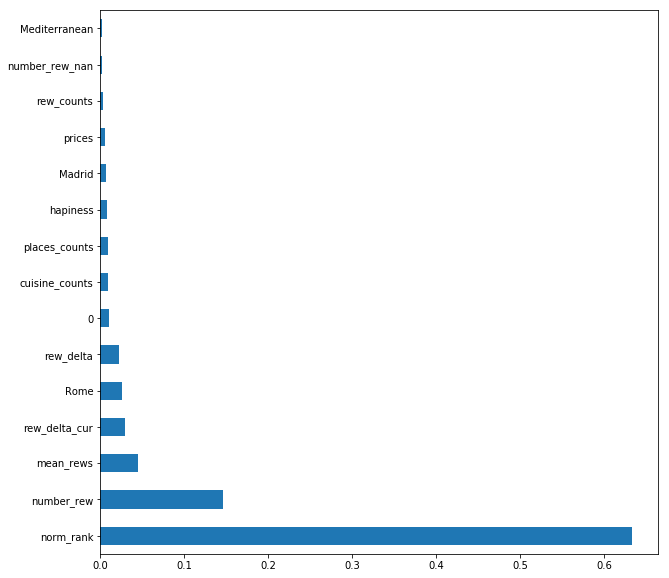

In [92]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan, \
                        cities_capital, countries, \
                        hapiness, \
                        rew_counts, \
                        pop_tourists], axis = 1)
model_func(df_preproc)

Эксперимент показал, что новый признак модель не улучшил. Оставим в модели признаки население города и количество туристов

# Final model test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.1968725

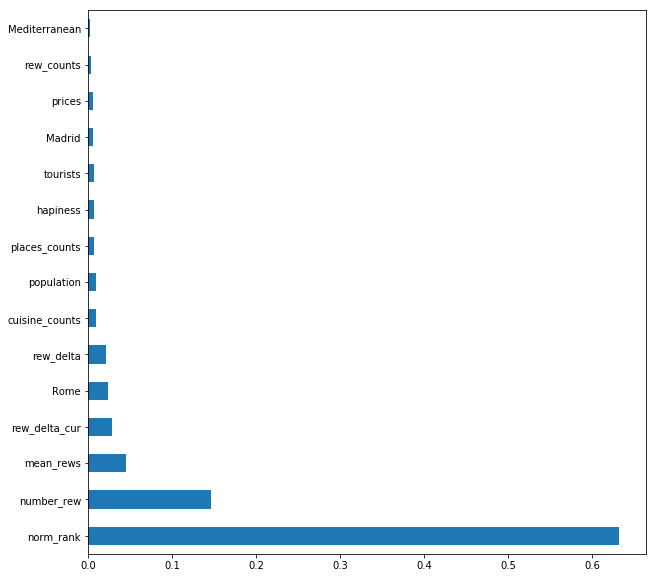

In [93]:
df_preproc = pd.concat([data.loc[:,['Rating', 'sample']], \
                        number_rew, number_rew_nan, norm_rank, mean_rews, places_counts, \
                        cities, prices, price_isnan, \
                        cuisine_counts, cuisine_style_df, \
                        rew_delta, rew_delta_cur,rew_delta_isnan, \
                        cities_pop, cities_capital, countries, \
                        tourists, hapiness, \
                        rew_counts], axis = 1)
model_func(df_preproc)

# Submission
готовим Submission на кагл

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE:  0.1656875


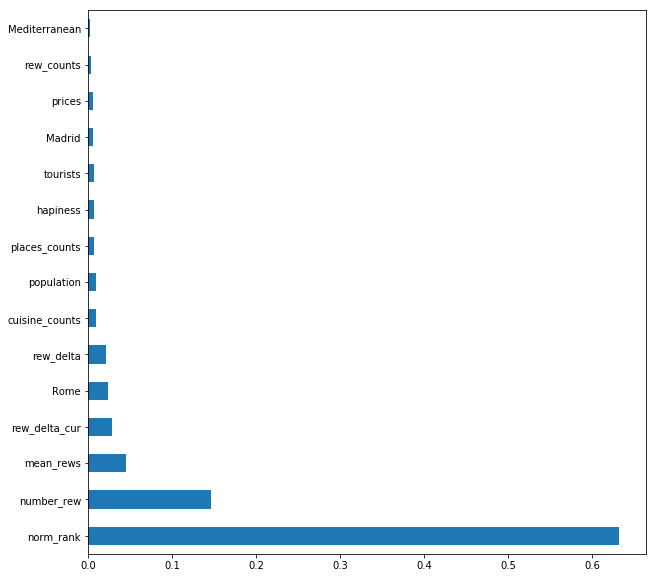

In [94]:
# выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)
    
RANDOM_SEED = 42
    
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

y_pred = np.round(y_pred * 2) / 2
print('MAE: ',metrics.mean_absolute_error(y_test, y_pred))
    
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [95]:
test_data = test_data.drop(['Rating'], axis=1)
sample_submission.Rating

0       2.0
1       2.5
2       4.0
3       1.0
4       4.0
       ... 
9995    3.0
9996    1.5
9997    4.5
9998    1.0
9999    2.5
Name: Rating, Length: 10000, dtype: float64

Обратила внимание, что Rating в датасете - заполняет значения от 1 до 5 с шагом 0.5. Поэтому, если округлить предсказание до ближайшеего x.5 числа, то предсказание улучшится.

In [96]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [97]:
predict_submission = np.round(predict_submission * 2)/2

In [98]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5
